In [32]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics
from scipy.fftpack import dct as DCT, idct as IDCT

# Importing our U-Net model
MY_UTILS_PATH = "../../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc

In [81]:
def py_dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def py_idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

    return dct_matrix

def tf_dct_in_blocks(im, block_size = 8):

    batch, rows, cols, chnls = im.shape

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((batch,rows, cols,chnls))
    for kk in range(batch):
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):

                block = im[kk,i:i+block_size, j:j+block_size,0]
                dct_matrix[kk,i:i+block_size,j:j+block_size,0] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = py_idct2d(block)

    return im_matrix


In [2]:
def dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho')),type=2,axis=-1,norm='ortho'))
    
    
def idct2d(mat):
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho')),type=2,axis=-1,norm='ortho'))

# Modified from:
# https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches(x):
    return K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )


def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad

In [3]:
import keras.backend as K

def dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data
    """
    
    patches = extract_patches(image)
    dct_patches = dct2d(patches)
    dct_image = extract_patches_inverse(image, dct_patches)
    
    return dct_image

def idct_layer(dctdata):
    """
    Input: single channel array representing dct coefficient data
    Output: single channel array representing image domain data
    """
    
    patches = extract_patches(dctdata)
    image_patches = idct2d(patches)
    image = extract_patches_inverse(dctdata, image_patches)
    
    return image

In [4]:
# Train and validation data paths
test_path = "../../../Gray/*.tif"

# Listing train and validation images
images = glob.glob(test_path)
test_images = images[45000:]

# Summary of images
print("Test set size:", len(test_images))

Test set size: 3624


In [5]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0

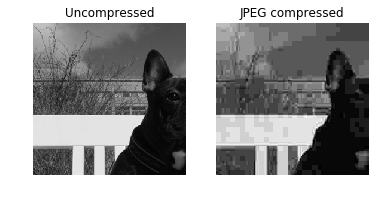

In [6]:
# Load uncompressed image
im1 = Image.open(test_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=5)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [91]:
def extract_blocks(tens, block_size = [1,8,8,1]):
    [batch, rows, cols, chnls] = K.tf.shape(tens)
    batch_blocks = K.tf.zeros([batch, rows, cols, chnls])
    
        for ii in range(0, rows, block_size):
            for jj in range(0, cols, block_size):

                block = im[i:i+block_size, j:j+block_size]
                dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

In [92]:
test = K.tf.py_func(dct_in_blocks,[test_unc[0,:,:,0]],np.float32)
print(test)
tf_eval(test)

Tensor("PyFunc_4:0", dtype=float32)


InvalidArgumentError: 0-th value returned by pyfunc_4 is double, but expects float
	 [[node PyFunc_4 (defined at <ipython-input-91-5045f72267fb>:1)  = PyFunc[Tin=[DT_FLOAT], Tout=[DT_FLOAT], token="pyfunc_4", _device="/job:localhost/replica:0/task:0/device:CPU:0"](PyFunc_4/input_0)]]

Caused by op 'PyFunc_4', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-5045f72267fb>", line 1, in <module>
    test = K.tf.py_func(dct_in_blocks,[test_unc[0,:,:,0]],np.float32)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 457, in py_func
    func=func, inp=inp, Tout=Tout, stateful=stateful, eager=False, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 281, in _internal_py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_script_ops.py", line 129, in py_func
    "PyFunc", input=input, token=token, Tout=Tout, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): 0-th value returned by pyfunc_4 is double, but expects float
	 [[node PyFunc_4 (defined at <ipython-input-91-5045f72267fb>:1)  = PyFunc[Tin=[DT_FLOAT], Tout=[DT_FLOAT], token="pyfunc_4", _device="/job:localhost/replica:0/task:0/device:CPU:0"](PyFunc_4/input_0)]]


In [7]:
im1_dct = dct_layer(test_unc)
im1_idct = idct_layer(im1_dct)

In [58]:
n=3

test = np.zeros([n, 256,256,1], dtype=np.float32)
patch_image = np.zeros([n, 256,256,1], dtype=np.float32)
hello = np.zeros([n, 256,256,1], dtype=np.float32)

for ii in range(n):
    test[ii,:,:,0] = test_unc[40*ii,:,:,0]
    patch_test = extract_patches(test)
    dct_patches = dct2d(patch_test)
    print(patch_test)
    print(dct_patches)
    patch_image = extract_patches_inverse(test, dct_patches)
    hello[ii,:,:,0] = dct_in_blocks(test[ii,:,:,0])


Tensor("ExtractImagePatches_21:0", shape=(3, 32, 32, 64), dtype=float32)
Tensor("transpose_19:0", shape=(3, 32, 32, 64), dtype=float32)
Tensor("ExtractImagePatches_23:0", shape=(3, 32, 32, 64), dtype=float32)
Tensor("transpose_21:0", shape=(3, 32, 32, 64), dtype=float32)
Tensor("ExtractImagePatches_25:0", shape=(3, 32, 32, 64), dtype=float32)
Tensor("transpose_23:0", shape=(3, 32, 32, 64), dtype=float32)


Tensor("truediv_8:0", shape=(2, 256, 256, 1), dtype=float32)


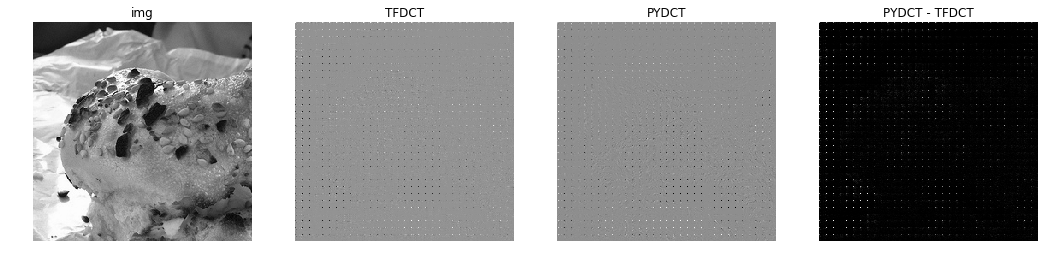

In [55]:
print(patch_image)
img = tf_eval(patch_image)

# Display the images
plt.figure(figsize=(18,9))
plt.subplot(1,4,1)
plt.imshow(test[1,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("img")
plt.subplot(1,4,2)
plt.imshow(img[1,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("TFDCT")
plt.subplot(1,4,3)
plt.imshow(hello,cmap = "gray")
plt.axis("off")
plt.title("PYDCT")
plt.subplot(1,4,4)
plt.imshow(abs(hello2 - img[1,:,:,0]),cmap = "gray")
plt.axis("off")
plt.title("PYDCT - TFDCT")
plt.show()

In [56]:
lala = abs(hello2 - img[1,:,:,0])
print(hello2.min(), hello2.max())
print(img[1,:,:,0].min(), img[1,:,:,0].max())
mse = metrics.compare_mse(np.float32(hello2),np.float32(img[1,:,:,0]))
print(mse)
print(lala.mean(), lala.std())

-6.814453601837158 7.811522483825684
-8.624078 6.346697
0.6622654311382399
0.24144150236950668 0.7771559877515106
